In [4]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import matplotlib.patches as patches
import pandas as pd
import re
import os

In [3]:
def read_seismic_cube(file_path):
    """
    :param file_path: Путь к файлу
    :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
    а также словарю сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
    """
    with segyio.open(file_path, 'r') as segyfile:
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        cube = segyio.tools.cube(segyfile)
        traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
    return x, y, z, traces

In [5]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
ilines, xlines, samples_0, traces = read_seismic_cube(file_path)
samples = list()
for i in range(len(samples_0)):
    samples.append(int(samples_0[i]))

In [16]:
# проход по всем разломам и составление всех точек в один большой словарь
def process_files(directory):
    files = os.listdir(directory)
    result = {}

    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(directory, file), 'r') as f:
                data = []
                for line in f:
                    fields = line.split()
                    if len(fields) == 8:
                        x = int(fields[2])
                        y = int(fields[1])
                        z = -int(float(fields[5]))
                        t = int(fields[7])
                        data.append([x, y, z, t])
                result[file] = data

    return result

In [17]:
directory = 'C:/HV/Seismic/datas/Faults_TWT_Charisma_fault_sticks_ASCII'
faults_original = process_files(directory)
print(faults_original)

{'Graben10_E.txt': [[5231, 1157, -1900, 1], [5194, 1157, -2505, 1], [5241, 1147, -1871, 2], [5201, 1147, -2489, 2], [5222, 1167, -1888, 3], [5188, 1167, -2511, 3], [5215, 1177, -1867, 4], [5180, 1177, -2511, 4], [5206, 1187, -1873, 5], [5173, 1187, -2496, 5], [5197, 1197, -1867, 6], [5162, 1197, -2511, 6]], 'Graben10_W.txt': [[5129, 1167, -1888, 1], [5158, 1167, -2509, 1], [5134, 1157, -1894, 2], [5165, 1157, -2492, 2], [5123, 1177, -1875, 3], [5151, 1177, -2488, 3], [5117, 1187, -1877, 4], [5143, 1187, -2491, 4], [5113, 1197, -1844, 5], [5139, 1197, -2508, 5], [5110, 1207, -1878, 6], [5133, 1207, -2514, 6], [5141, 1147, -1887, 7], [5173, 1147, -2483, 7], [5149, 1137, -1887, 8], [5182, 1137, -2483, 8]], 'Graben11_E.txt': [[5241, 1117, -1893, 1], [5208, 1117, -2499, 1], [5249, 1107, -1878, 2], [5217, 1107, -2488, 2], [5235, 1127, -1868, 3], [5204, 1127, -2495, 3], [5227, 1137, -1868, 4], [5194, 1137, -2482, 4], [5219, 1147, -1873, 5], [5183, 1147, -2476, 5]], 'Graben11_W.txt': [[5136, 1

In [18]:

"""
Сборка координат в один список попарно
Если точек больше 2, то берется минимальное и максимальное значение по глубинам
Если точка 1, то она не учитывается в разломах
"""
faults_final = {}

for key in faults_original:
    dop_spisok = []
    z_spisok = []
    faults_final[key] = []

    for i in range(len(faults_original[key])):
        if len(dop_spisok) == 0:
            dop_spisok.append(faults_original[key][i])
            z_spisok.append(faults_original[key][i][2])
        elif len(dop_spisok) == 1:
            if dop_spisok[0][3] == faults_original[key][i][3]:
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])
            else:
                dop_spisok.clear()
                z_spisok.clear()
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])
        elif len(dop_spisok) == 2:
            if dop_spisok[0][3] == faults_original[key][i][3]:
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])
            else:
                #faults_final.append(dop_spisok[:])
                faults_final[key].append(dop_spisok[:])
                dop_spisok.clear()
                z_spisok.clear()
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])
        else:
            if dop_spisok[0][3] == faults_original[key][i][3]:
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])
            else:
                faults_final[key].append(
                    [dop_spisok[z_spisok.index(min(z_spisok))], dop_spisok[z_spisok.index(max(z_spisok))]])
                dop_spisok.clear()
                z_spisok.clear()
                dop_spisok.append(faults_original[key][i])
                z_spisok.append(faults_original[key][i][2])

In [9]:
def line_km(spisok):
    z_min = -2386
    z_max = -2142
    if (-2142 < spisok[0][2]) and (spisok[1][2] < -2386):
        t1 = (z_max - spisok[0][2]) / (spisok[1][2] - spisok[0][2])
        x1 = round(spisok[0][0] + (spisok[1][0] - spisok[0][0]) * t1)
        y1 = round(spisok[0][1] + (spisok[1][1] - spisok[0][1]) * t1)
        z1 = z_max

        t2 = (z_min - spisok[0][2]) / (spisok[1][2] - spisok[0][2])
        x2 = round(spisok[0][0] + (spisok[1][0] - spisok[0][0]) * t2)
        y2 = round(spisok[0][1] + (spisok[1][1] - spisok[0][1]) * t2)
        z2 = z_min
        return [[x1, y1, z1], [x2, y2, z2], 0]
    elif (-2142 > spisok[0][2]) and (spisok[1][2] < -2386):
        t2 = (z_min - spisok[0][2]) / (spisok[1][2] - spisok[0][2])
        x2 = round(spisok[0][0] + (spisok[1][0] - spisok[0][0]) * t2)
        y2 = round(spisok[0][1] + (spisok[1][1] - spisok[0][1]) * t2)
        z2 = z_min
        return [[spisok[0][0], spisok[0][1], spisok[0][2]], [x2, y2, z2], 1]
    elif (-2142 < spisok[0][2]) and (spisok[1][2] > -2386):
        t1 = (z_max - spisok[0][2]) / (spisok[1][2] - spisok[0][2])
        x1 = round(spisok[0][0] + (spisok[1][0] - spisok[0][0]) * t1)
        y1 = round(spisok[0][1] + (spisok[1][1] - spisok[0][1]) * t1)
        z1 = z_max
        return [[x1, y1, z1], [spisok[1][0], spisok[1][1], spisok[1][2]], 2]
    else:
        return [[spisok[0][0], spisok[0][1], spisok[0][2]], [spisok[1][0], spisok[1][1], spisok[1][2]], 3]

In [19]:
faults_to_cube_2 = {}
for key in faults_final:
    faults_to_cube_2[key] = []
    for i in range(len(faults_final[key])):
        faults_to_cube_2[key].append(line_km(sorted(faults_final[key][i], reverse=True, key=lambda xx: xx[2])))
maps_of_top = {}
for key in traces:
    maps_of_top[key] = traces[key][0]

In [22]:
def show_map(maps, k):
    # срез карты по осям ХУ

    # Извлечение данных для отрисовки
    points = []
    values = []
    for coord_str, value in maps.items():
        y, x = map(int, coord_str.split('_'))
        points.append((x, y))
        values.append(value)

    # Создание графика
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(x=list(zip(*points))[0], y=list(zip(*points))[1], c=values)
    plt.xticks([ilines[0], ilines[100], ilines[200], ilines[300], ilines[400], ilines[500], ilines[-1]])
    plt.yticks([xlines[0], xlines[100], xlines[200], xlines[300], xlines[400], xlines[500], xlines[-1]])
    plt.title('Карта')
    plt.ylabel('Инлайны')
    plt.xlabel('Кросслайны')
    plt.colorbar(scatter, label='Шкала значений сейсмотрассы')

    x_coords = []
    y_coords = []
    # проходимся по первому элементу в каждом подсписке и добавляем его координаты в список
    for key in faults_to_cube_2:
        x_coords = []
        y_coords = []
        for sublist in faults_to_cube_2[key]:
            x_coords.append(sublist[k][0])
            y_coords.append(sublist[k][1])
        plt.plot(x_coords, y_coords, color='red', linewidth=2)  # Линия красного цвета с толщиной 2

    plt.grid(False)  # Отключение сетки
    plt.show()






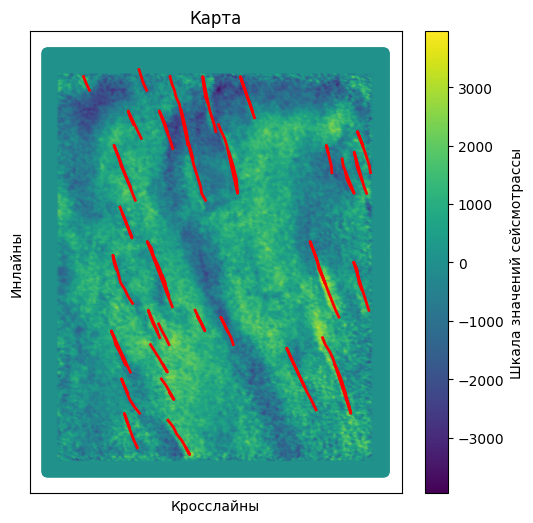

{'Graben10_E.txt': [[[5216, 1157, -2142], [5201, 1157, -2386], 0], [[5223, 1147, -2142], [5208, 1147, -2386], 0], [[5208, 1167, -2142], [5195, 1167, -2386], 0], [[5200, 1177, -2142], [5187, 1177, -2386], 0], [[5192, 1187, -2142], [5179, 1187, -2386], 0]], 'Graben10_W.txt': [[[5141, 1167, -2142], [5152, 1167, -2386], 0], [[5147, 1157, -2142], [5160, 1157, -2386], 0], [[5135, 1177, -2142], [5146, 1177, -2386], 0], [[5128, 1187, -2142], [5139, 1187, -2386], 0], [[5125, 1197, -2142], [5134, 1197, -2386], 0], [[5120, 1207, -2142], [5128, 1207, -2386], 0], [[5155, 1147, -2142], [5168, 1147, -2386], 0]], 'Graben11_E.txt': [[[5227, 1117, -2142], [5214, 1117, -2386], 0], [[5235, 1107, -2142], [5222, 1107, -2386], 0], [[5221, 1127, -2142], [5209, 1127, -2386], 0], [[5212, 1137, -2142], [5199, 1137, -2386], 0]], 'Graben11_W.txt': [[[5150, 1117, -2142], [5164, 1117, -2386], 0], [[5144, 1127, -2142], [5156, 1127, -2386], 0], [[5139, 1137, -2142], [5151, 1137, -2386], 0], [[5154, 1107, -2142], [5168

In [23]:
show_map(maps_of_top, 0)
print(faults_to_cube_2)

razrezi = {}
for key in faults_to_cube_2:
    a = faults_to_cube_2[key][0][0][0]
    b = faults_to_cube_2[key][-1][0][0]
    razrezi[key] = a + (b - a) // 2

print(razrezi)

In [ ]:
def show_razrez(X, name):
    map_xlines_samples = {}
    for i in range(len(xlines)):
        for j in range(len(samples)):
            map_xlines_samples[f"{xlines[i]}_{samples[j]}"] = traces[f"{X}_{xlines[i]}"][j]

    # Извлечение данных для отрисовки
    points = []
    values = []
    for coord_str, value in map_xlines_samples.items():
        x, y = map(int, coord_str.split('_'))
        points.append((x, y * (-1)))
        values.append(value)

    # Создание графика
    plt.figure(figsize=(5, 5))
    scatter = plt.scatter(x=list(zip(*points))[0], y=list(zip(*points))[1], c=values)
    plt.xticks([xlines[0], xlines[100], xlines[200], xlines[300], xlines[400], xlines[500], xlines[-1]])
    plt.yticks([(-1) * samples[0], (-1) * samples[50], (-1) * samples[100], (-1) * samples[-1]])
    plt.title(name)
    plt.xlabel('Кросcлайны')
    plt.ylabel('Глубины')
    plt.colorbar(scatter, label='Шкала  значений сейсмотрассы')

    for key in faults_to_cube_2:
        x_coords = []
        y_coords = []
        for i in range(len(faults_to_cube_2[key])):
            for j in range(2):
                if (X - 3) <= faults_to_cube_2[key][i][j][0] <= (X + 3):
                    #if faults_to_cube_2[key][i][j][0] == X:
                    x_coords.append(faults_to_cube_2[key][i][j][1])
                    y_coords.append(faults_to_cube_2[key][i][j][2])
                    plt.plot(x_coords, y_coords, color='red', linewidth=2,
                             alpha=0.3)  # Линия красного цвета с толщиной 2

    plt.grid(False)  # Отключение сетки
    plt.show()

In [ ]:
for key in razrezi:
    show_razrez(razrezi[key], key)